# Import libraries

In [27]:
import os
import sys
import datetime

from termcolor import colored, cprint

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sys
from os import listdir

import numpy as np
import pandas as pd  # Import Pandas and Numpy to create databases
import tensorflow as tf  # Import tensorflow to do tensor manipulations
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from chasm.glob import glob
scaler = StandardScaler()

In [28]:
phenotypes_labels = {
    "bc": "Breast Cancer",
    "cad": "Coronary Artery Disease",
    "ms": "Multiple Sclerosis",
    "t2d": "Type 2 Diabetes",
    "pc": "Prostate Cancer",
    "ibd": "Inflammatory Bowel Disease"
}

scenario_labels = {
    "no_cov": "no covariates",
    "abyss": "Abyss correction",
    "cov": "PCA correction",
    "abyss_cov": "Abyss + PCA as covariates"
}

# Load Sumstats

In [29]:
disease = "ms"
scenario = "abyss"
max_maf = 0.5
min_maf = 0
logp_min = 6
logp_max = 100
P_cutoff = 5e-8
PCs = 15
nr_snps = 2500
bin =17

In [30]:
path_input = glob.PATH_GENO + f"/09_summary_statistics/{disease}/{scenario}"

In [31]:
list_of_bins = os.listdir(path_input)

In [32]:
biny

'bin_17_sumstat.pkl'

In [33]:
list_of_dfs = []
for biny in list_of_bins[0:1]:
    biny = f"bin_{bin}_sumstat.pkl"
    try:
        temp = pd.read_pickle(path_input+f"/{biny}")
        temp['bin'] = biny.split('_')[1]
        
        # Sort by -logp in descending order and take the top 1000 SNPs
        top_snps = temp.sort_values(by='-logp', ascending=False).head(nr_snps)
        
        list_of_dfs.append(top_snps)
    except Exception as e:
        print(e)
        print(f"Problem with chrom {biny}")

# Concatenating the top SNPs from each bin
sumstat = pd.concat(list_of_dfs)

# Sorting by chromosome if needed
sumstat = sumstat.sort_values(by='#CHROM', ascending=True)

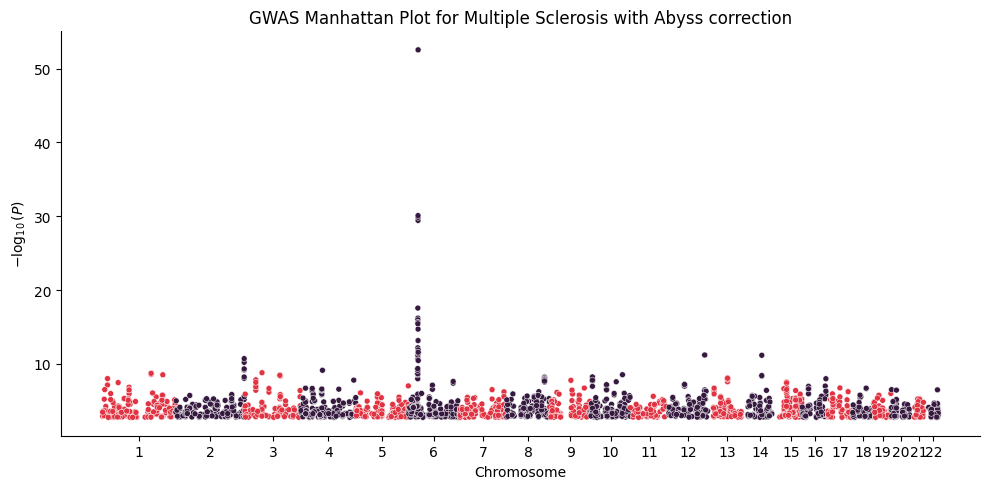

In [34]:
running_pos = 0
cumulative_pos = []
for chrom, group_df in sumstat.groupby('#CHROM'):
    cumulative_pos.append(group_df['POS'] + running_pos)
    running_pos += group_df['POS'].max()

sumstat['cumulative_pos'] = pd.concat(cumulative_pos)
sumstat['SNP number'] = sumstat.index

# Define two contrasting colors from the rocket palette
palette = sns.color_palette("rocket", as_cmap=False)
color1 = palette[3]  # First color of the palette
color2 = palette[0] # Last color of the palette, for maximum contrast

# Function to assign color based on chromosome
def assign_color(chrom_number):
    return color1 if chrom_number % 2 == 0 else color2

# Apply the function to create a color column
sumstat['color'] = sumstat['#CHROM'].apply(assign_color)

chrom_midpoints = []
for chrom, group_df in sumstat.groupby('#CHROM'):
    midpoint = group_df['cumulative_pos'].min() + (group_df['cumulative_pos'].max() - group_df['cumulative_pos'].min()) / 2
    chrom_midpoints.append(midpoint)

# Plotting
g = sns.relplot(
    data=sumstat,
    x='cumulative_pos',
    y='-logp',
    aspect=2,
    hue='color',
    palette=[color1, color2],
    legend=False,
    size=3 
)


# Set x-axis ticks and labels with reversed chromosome order
chrom_labels = np.sort(sumstat['#CHROM'].unique()) # Reversing the order of chromosomes

# Set the title and x-axis, y-axis labels
g.set(title=f"GWAS Manhattan Plot for {phenotypes_labels[disease]} with {scenario_labels[scenario]}")
g.set(xticks=chrom_midpoints, xticklabels=chrom_labels)
g.set_axis_labels("Chromosome", r"$-\log_{10}(P)$")  # Set y-axis label with subscript

# Set the tick labels at a 45-degree angle
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Optional: Improve the layout
plt.tight_layout()
plt.show()

# Find geno and mafs for selected SNPs

In [35]:
sumstat

,snp,consts,beta_snp,beta_maf,std_err,Z,P,#CHROM,POS,-logp,bin,cumulative_pos,SNP number,color
2139,1:241222137:C_T_T,1.703773,0.022248,-1.603145,0.010096,2.203682,0.027643,1,241222137,3.588391,17,241222137,2139,"(0.20973515, 0.09747934, 0.24238489)"
32746,1:248496863:A_G_G,0.621496,0.034557,-0.168453,0.014832,2.329927,0.019894,1,248496863,3.917350,17,248496863,32746,"(0.20973515, 0.09747934, 0.24238489)"
16386,1:188009528:A_G_A,0.369264,0.025146,0.177241,0.010291,2.443589,0.014615,1,188009528,4.225733,17,188009528,16386,"(0.20973515, 0.09747934, 0.24238489)"
34826,1:186417697:C_T_T,-0.082334,-0.024736,0.783793,0.010120,-2.444333,0.014585,1,186417697,4.227790,17,186417697,34826,"(0.20973515, 0.09747934, 0.24238489)"
16385,1:187992993:A_G_A,0.401552,0.025166,0.133238,0.010291,2.445358,0.014543,1,187992993,4.230623,17,187992993,16385,"(0.20973515, 0.09747934, 0.24238489)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2987,22:36130082:G_T_G,0.227907,0.020535,0.362496,0.010063,2.040661,0.041395,22,36130082,3.184585,17,2809078937,2987,"(0.8833417, 0.19830556, 0.26014181)"
13764,22:27328318:C_T_C,1.711549,-0.024015,-1.617638,0.010398,-2.309580,0.020997,22,27328318,3.863369,17,2800277173,13764,"(0.8833417, 0.19830556, 0.26014181)"
20353,22:44564407:C_T_C,0.013973,-0.019371,0.647053,0.010303,-1.880021,0.060228,22,44564407,2.809617,17,2817513262,20353,"(0.8833417, 0.19830556, 0.26014181)"
23494,22:25501854:C_T_C,0.512624,0.019465,-0.017526,0.010290,1.891634,0.058662,22,25501854,2.835966,17,2798450709,23494,"(0.8833417, 0.19830556, 0.26014181)"


In [41]:
unique_bins = list(sumstat['bin'].unique())

In [78]:
genos = []
mafs = []
for unique_bin in unique_bins:
    temp_sumstat = sumstat[sumstat['bin'] == unique_bin]
    path_geno_mapping = glob.PATH_GENO + f"/04_LD_blocks/{PCs}_PCs/bin_{unique_bin}"
    map = pd.read_pickle(path_geno_mapping + f"/mapping.pkl")

    path_dims_of_maf = glob.PATH_GENO + f"/08_MAF_probability_landscape/{disease}/bin_{bin}"
    dims_of_maf = os.listdir(path_dims_of_maf)[0]
    path_maf = path_dims_of_maf + f"/{dims_of_maf}"
    
    for index, row in temp_sumstat.head(2).iterrows():
        print(row['snp'])
        path_df = map[map['Position'] == str(row['POS'])]
        snp_id = path_df.iloc[0]['Chromosome'] + ":" + path_df.iloc[0]['Position'] + ":" + path_df.iloc[0]['Alls2']
        path = path_df.iloc[0]['path']
        print(snp_id)
        print(path)
        file_with_snp = [f for f in listdir(path_geno_mapping) if f.startswith(path)][0]
        path_file_genos = path_geno_mapping + f"/" + file_with_snp
        geno = pd.read_pickle(path_file_genos)[[snp_id]]
        genos.append(geno)

        path_file_maf = path_maf + f"/" + file_with_snp
        maf = pd.read_pickle(path_file_maf)[[snp_id]]
        mafs.append(maf)

1:241222137:C_T_T
1:241222137:C_T_T
2_0
1:248496863:A_G_G
1:248496863:A_G_G
23_0


In [79]:
concat_geno = pd.concat(genos, axis=1)

In [80]:
concat_geno

,1:241222137:C_T_T,1:248496863:A_G_G
0,0,1
1,1,1
2,1,1
3,1,0
4,-1,0
...,...,...
69450,1,1
69451,1,1
69452,1,1
69453,0,1


In [81]:
concat_maf = pd.concat(mafs, axis=1)
concat_maf

,1:241222137:C_T_T,1:248496863:A_G_G
0,0.740603,1.091832
1,0.762315,0.871489
2,0.730787,0.935146
3,0.757648,0.522617
4,0.749951,0.702869
...,...,...
69450,0.752263,1.073354
69451,0.755886,1.050079
69452,0.740613,0.886875
69453,0.743460,1.073133
